In [10]:
import sys
import os

# Adiciona o diretório raiz do projeto ao sys.path
sys.path.append(os.path.abspath("../../../"))  

## Game of Life (Jogo da Vida)

O **Game of Life**, criado por John Conway, é um autômato celular clássico com regras simples:

- Uma célula **viva** permanece viva com 2 ou 3 vizinhos vivos.
- Uma célula **morta** revive com exatamente 3 vizinhos vivos.

Essa regra pode ser implementada como a seguir:

In [11]:
def rule(self, idx):
        """
        Aplica a regra do Game of Life para uma célula do índice `idx`.

        Regras:
        - Qualquer célula viva com menos de dois ou mais de três vizinhos vivos morre.
        - Qualquer célula viva com dois ou três vizinhos sobrevive.
        - Qualquer célula morta com exatamente três vizinhos vivos se torna viva.

        Retorna:
        - 0 para célula morta
        - 1 para célula viva
        """
        value = self.gdf.loc[idx, self.state_attr]
        neighs = self.neighs(idx)
        count = neighs[self.state_attr].fillna(0).sum()

        if value == 1:
            return 1 if 2 <= count <= 3 else 0
        else:
            return 1 if count == 3 else 0


Sabendo-se a regra, vamos definir o modelo completo

In [12]:
from dissmodel.core import Environment
from dissmodel.geo import regular_grid, CellularAutomaton, fill, FillStrategy
from dissmodel.visualization.map import Map
from matplotlib.colors import ListedColormap
import random
from libpysal.weights import Queen


## 🧩 Componentes do Modelo

- A grade é inicializada com padrões (ex: `glider`, `toad`, etc.), usando `fill(..., strategy=FillStrategy.PATTERN)`.
- A vizinhança usada é a **Queen**, que considera os 8 vizinhos ao redor.
- A regra de atualização verifica o número de vizinhos vivos para decidir o próximo estado.

In [13]:

class GameOfLife(CellularAutomaton):
    """
    Implementação do Game of Life como um autômato celular espacial.

    A célula sobrevive, nasce ou morre conforme o número de vizinhos vivos.
    """

    def initialize (self):
        # Padrões clássicos do Game of Life
        patterns = {
            "glider": [
                [0, 1, 0],
                [0, 0, 1],
                [1, 1, 1]
            ],
            "toad": [
                [0, 1, 1, 1],
                [1, 1, 1, 0]
            ],
            "blinker": [
                [1, 1, 1]
            ]
        }
        # assume uma grade com altura e largura iguais
        grid_dim = int(len(self.gdf) ** 0.5)


        # Inserção aleatória dos padrões
        for name, pattern in patterns.items():
            start_x = random.randint(0, grid_dim - len(pattern))
            start_y = random.randint(0, grid_dim - len(pattern[0]))
            
            fill(
                strategy=FillStrategy.PATTERN,
                gdf=self.gdf,
                attr="state",
                pattern=pattern,
                start_x=start_x,
                start_y=start_y
            )

    def setup(self):
        """
        Inicializa a vizinhança usando a estratégia Queen.
        """
        self.create_neighborhood(strategy=Queen, use_index=True)

    def rule(self, idx):
        """
        Aplica a regra do Game of Life para uma célula do índice `idx`.

        Regras:
        - Qualquer célula viva com menos de dois ou mais de três vizinhos vivos morre.
        - Qualquer célula viva com dois ou três vizinhos sobrevive.
        - Qualquer célula morta com exatamente três vizinhos vivos se torna viva.

        Retorna:
        - 0 para célula morta
        - 1 para célula viva
        """
        value = self.gdf.loc[idx, self.state_attr]
        neighs = self.neighs(idx)
        count = neighs[self.state_attr].fillna(0).sum()

        if value == 1:
            return 1 if 2 <= count <= 3 else 0
        else:
            return 1 if count == 3 else 0


Cria a grade com uma dada dimensão

In [14]:
# Criação da grade espacial
grid = regular_grid(dimension=(20, 20), resolution=1, attrs={'state': 0})

Para execução do modelo, define-se um ambiente.

In [15]:

env = Environment(end_time=10, start_time=0)

Instancia-se o modelo

In [16]:
model = GameOfLife(gdf=grid)
model.initialize()

Um map é um tipo especial de "modelo", que é tambem sera gerenciado pelo environmente

In [17]:

plot_params = {
    "column": "state",
    "cmap": ListedColormap(['green', 'red']),
    "ec": "black"
}

m = Map(
        gdf=grid,
        plot_params=plot_params
)

instanciado o modelo, e Map, pode-s inicia a execução

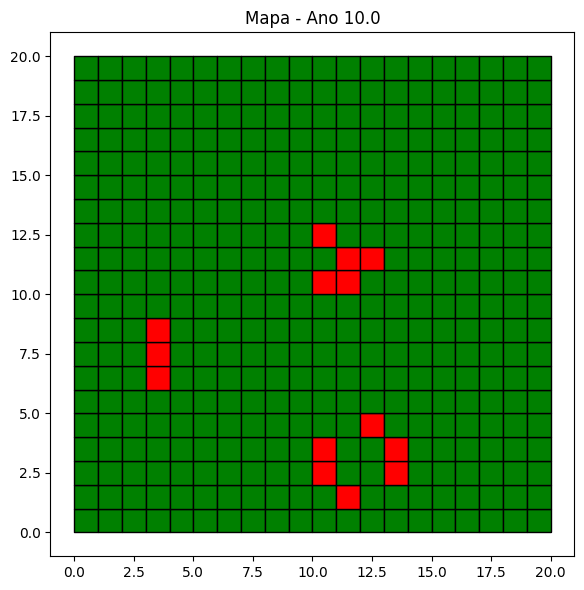

In [9]:
env.run()